# TESIS 
## Digital Pathology: Tubule Formations Analisys

Notebook: adapted from: 

- Author: Fran Pérez 
- **Pontificia Universidad Católica del Péru**

### Importing Libraris

In [19]:
import os
import numpy as np
import cv2
from glob import glob
import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, MaxPool2D,AveragePooling2D
from tensorflow.keras.layers import  GlobalAveragePooling2D, MaxPooling2D, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2,VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [20]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.3.1


**Seeding**

In [21]:
np.random.seed(40)
tf.random.set_seed(40)

### Hyperparameters

In [43]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 1
LR = 1e-4

PATH = "Tubule/"

## Dataset

The dataset has been collected from BracaHad
- link: https://bmcresnotes.biomedcentral.com/articles/10.1186/s13104-019-4121-7

The data has been splitted into (80:10:10) ratio. Training, Validation and testing respectively. 

In [44]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "process/*")))
    masks = sorted(glob(os.path.join(path, "mask/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

Reading the images and masks

In [45]:
def read_image(path):
    path = path.decode()
    #print(path)
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    #print('path mask: ', path)
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

Building the pipeline

In [46]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [47]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  130
Validation data:  16
Testing data:  16


In [27]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

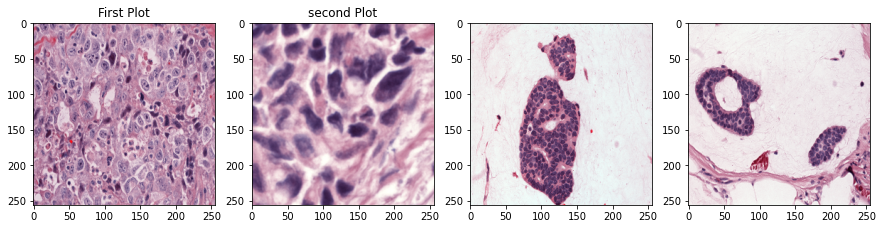

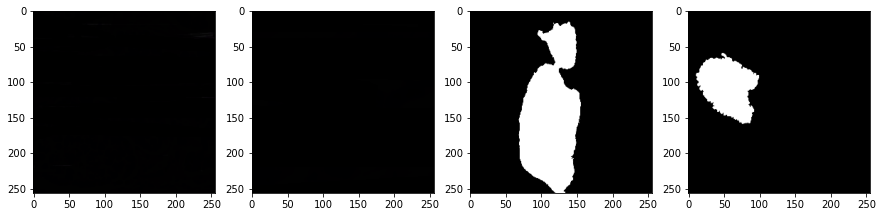

In [28]:
fig = plt.figure(figsize=(15, 15))
#fig.suptitle('This is a somewhat long figure title', fontsize=16)
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))
a.title.set_text('First Plot')
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)
a.title.set_text('second Plot')
a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 1.4)
a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[4]))
imgplot.set_clim(0.0, 1.4)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[4]))
imgplot.set_clim(0.0, 1.4)


## MODEL

In [29]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [30]:
model = model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________________

## Metrics
- Dice coef
- Accuracy

In [31]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Training

In [32]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [33]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [34]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4), ## after no improvement of val loss in 4 val=val*0.1
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False) #Stops after no improvemente of val_loss (10 times)
]

In [35]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
 )


Epoch 1/30
778/778 [==============================] - 309s 397ms/step - loss: 0.7876 - dice_coef: 0.2124 - recall_1: 0.5723 - precision_1: 0.3258 - val_loss: 0.7835 - val_dice_coef: 0.2165 - val_recall_1: 0.2070 - val_precision_1: 0.5714
Epoch 2/30
778/778 [==============================] - 305s 392ms/step - loss: 0.7569 - dice_coef: 0.2431 - recall_1: 0.5250 - precision_1: 0.3729 - val_loss: 0.7481 - val_dice_coef: 0.2519 - val_recall_1: 0.3593 - val_precision_1: 0.4752
Epoch 3/30
778/778 [==============================] - 307s 395ms/step - loss: 0.7356 - dice_coef: 0.2644 - recall_1: 0.5186 - precision_1: 0.4035 - val_loss: 0.7417 - val_dice_coef: 0.2583 - val_recall_1: 0.3931 - val_precision_1: 0.4595
Epoch 4/30
778/778 [==============================] - 303s 389ms/step - loss: 0.7143 - dice_coef: 0.2857 - recall_1: 0.5132 - precision_1: 0.4333 - val_loss: 0.7365 - val_dice_coef: 0.2635 - val_recall_1: 0.4089 - val_precision_1: 0.4444
Epoch 5/30
778/778 [============================

### Save the model

In [36]:
model.save('mobunet3.h5')

### Show Train Plots

### Evaluation 

In [48]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

16/16 [==============================] - 1s 42ms/step - loss: 0.7139 - dice_coef: 0.2861 - recall_1: 0.5033 - precision_1: 0.4312


[0.7139294147491455,
 0.2860705852508545,
 0.5032728314399719,
 0.4312317669391632]

### Results

In [49]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [50]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

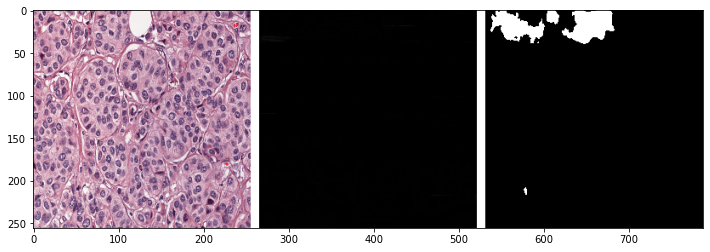

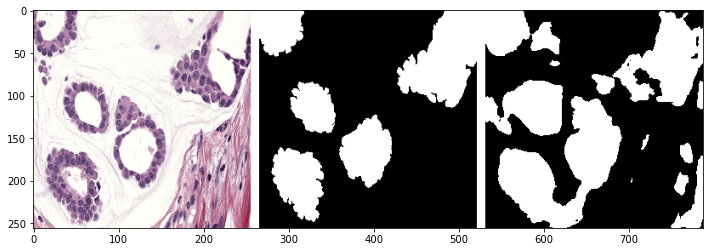

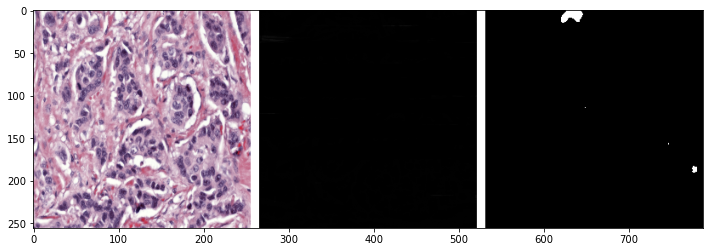

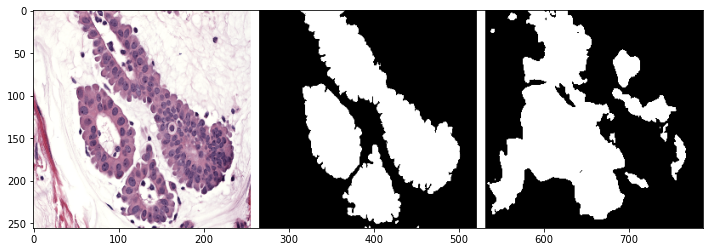

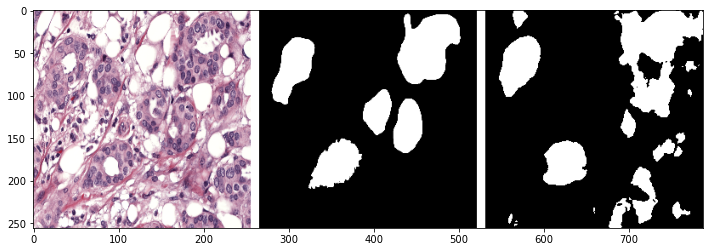

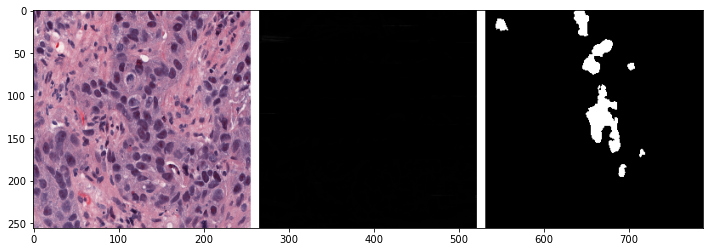

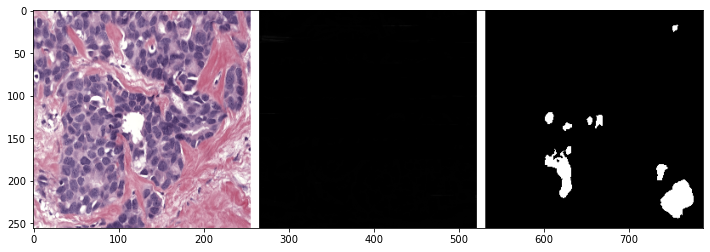

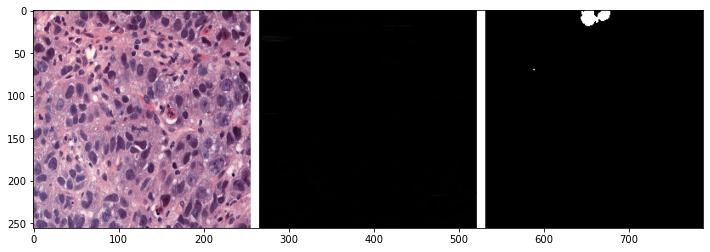

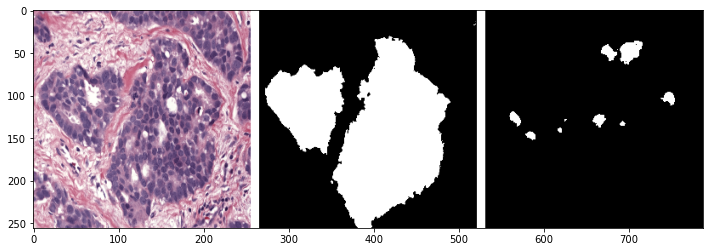

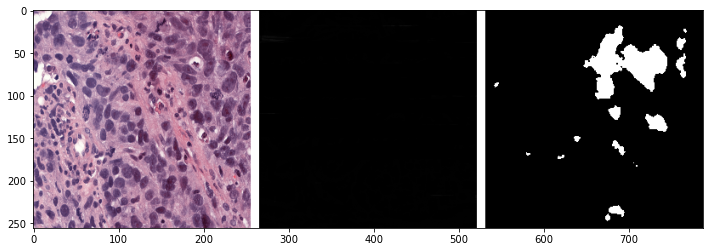

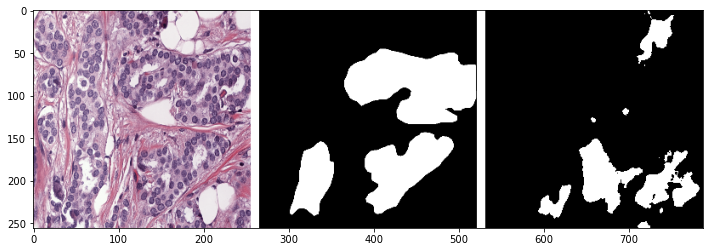

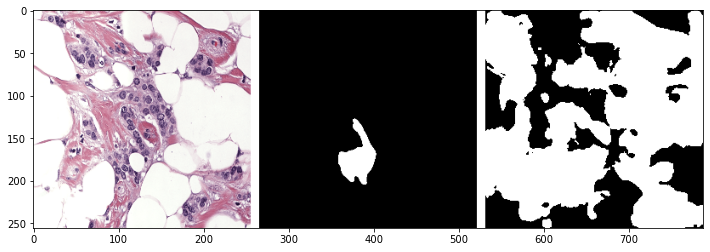

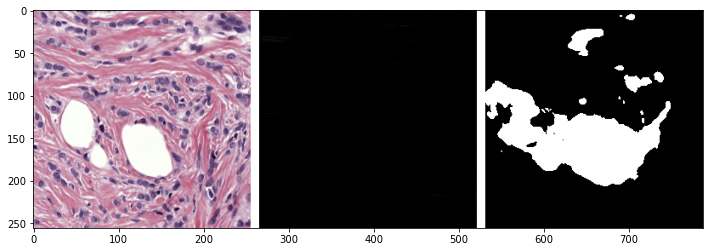

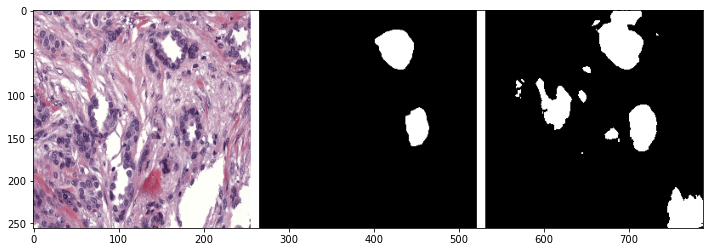

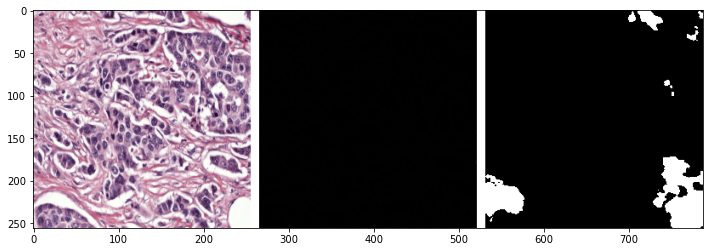

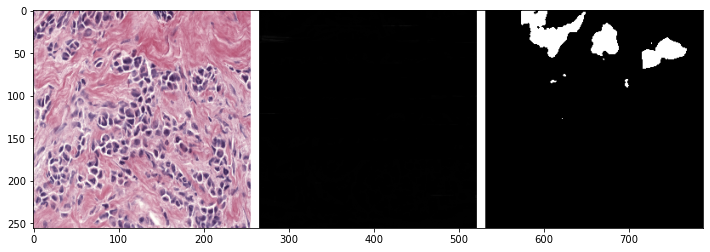

In [52]:
for i, (x, y) in enumerate(zip(test_x[:16], test_y[:16])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)